In [1]:
import sys
sys.path.insert(0, '../')
from lib import *

%matplotlib inline

DEBUG = False;


## Single Run

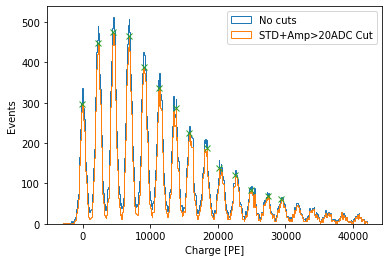

In [2]:
# Let's create a function to model and create data

# WEEK="APSAIA_VUV";
WEEK="DAPHNE_VIS";
path="/scr/neutrinos/rodrigoa/"+WEEK+"/joython/"
Runs=open_runs_table("../macros/"+WEEK+".xlsx")
Runs=Runs[Runs["Type"]=="Visible"]

for ch in [5]:
    r=0;
    # for run in Runs["Run"].array:
    for run in [4]:
        run_path=path+"run"+str(run).zfill(2)+"/";
        compress=False
        Pedestal_vars=open_run_var(run_path,"Pedestal_vars",[ch],compressed=compress)
        Charge_vars  =open_run_var(run_path ,"Charge_vars" ,[ch],compressed=compress)
        Peak_vars    =open_run_var(run_path ,"Peak_vars"   ,[ch],compressed=compress)
        Peak_vars    =open_run_var(run_path ,"Peak_vars"   ,[ch],compressed=compress)
    for run in [Runs.iloc[2]["Run"]]:
        run_path=path+"run"+str(run).zfill(2)+"/";
        Average_waveform  =open_ch_var(run_path ,"Avg_wvf"   ,ch,compressed=compress)

Ped_CUT=Pedestal_vars[ch]["STD"]<20

plt.hist(Charge_vars[ch]["ChargeRangeAverageWvf"]                        ,500,np.array([-0.1,1.4])*3e4,histtype="step");
plt.hist(Charge_vars[ch]["ChargeRangeAverageWvf"][Ped_CUT]               ,500,np.array([-0.1,1.4])*3e4,histtype="step");
counts,bins= np.histogram(Charge_vars[ch]["ChargeRangeAverageWvf"][Ped_CUT],500,np.array([-0.1,1.4])*3e4);

plt.legend(["No cuts","STD+Amp>20ADC Cut","STD+Amp>40ADC Cut","Best Fit"],loc="upper right")
plt.xlabel("Charge [PE]")
plt.ylabel("Events")
# plt.ylim([1,2e3])

peaks=find_peaks(counts,height=50,width=5)
plt.plot(bins[peaks[0]],peaks[1]["peak_heights"],"x")

## Deconvolution

In [3]:
for run in [4]:
    run_path=path+"run"+str(run).zfill(2)+"/";
    Pedestal_vars=open_ch_var(run_path,"Pedestal_vars",ch,compressed=compress)
    RawADC=open_ch_var(run_path,"RawADC",ch,compressed=True)
    ADC=substract_Pedestal((RawADC,Pedestal_vars,1))
    del RawADC


In [7]:
DEBUG=False
from lib.dec_functions import gauss
light2sPE_Factor=100/2.1
# light2sPE_Factor=1
XA_SER=Average_waveform["AvWvf_Center_Peak"]/light2sPE_Factor
presig=100

XA_SER=np.concatenate([XA_SER[np.argmax(XA_SER)-presig:],np.zeros(XA_SER[:np.argmax(XA_SER)-presig].shape[0])])
XA_SER_FFT  =np.fft.rfft(XA_SER) 

gauss_F=gauss(np.arange(len(XA_SER_FFT)),sigma=30,n=2)

In [11]:
#Deconvolve
ADC_dec=deconvolve(ADC,XA_SER,gauss_F)

if DEBUG:
    plt.plot(ADC_dec[1])
#recalculate pedestal
Pedestal_vars_SW=compute_Pedestal_slidingWindows(ADC_dec)
ADC_dec=substract_Pedestal((ADC_dec,Pedestal_vars_SW,1))
if DEBUG:
    plt.plot(ADC_dec[1])

charge=np.sum(ADC_dec[:,900:1200],axis=1)


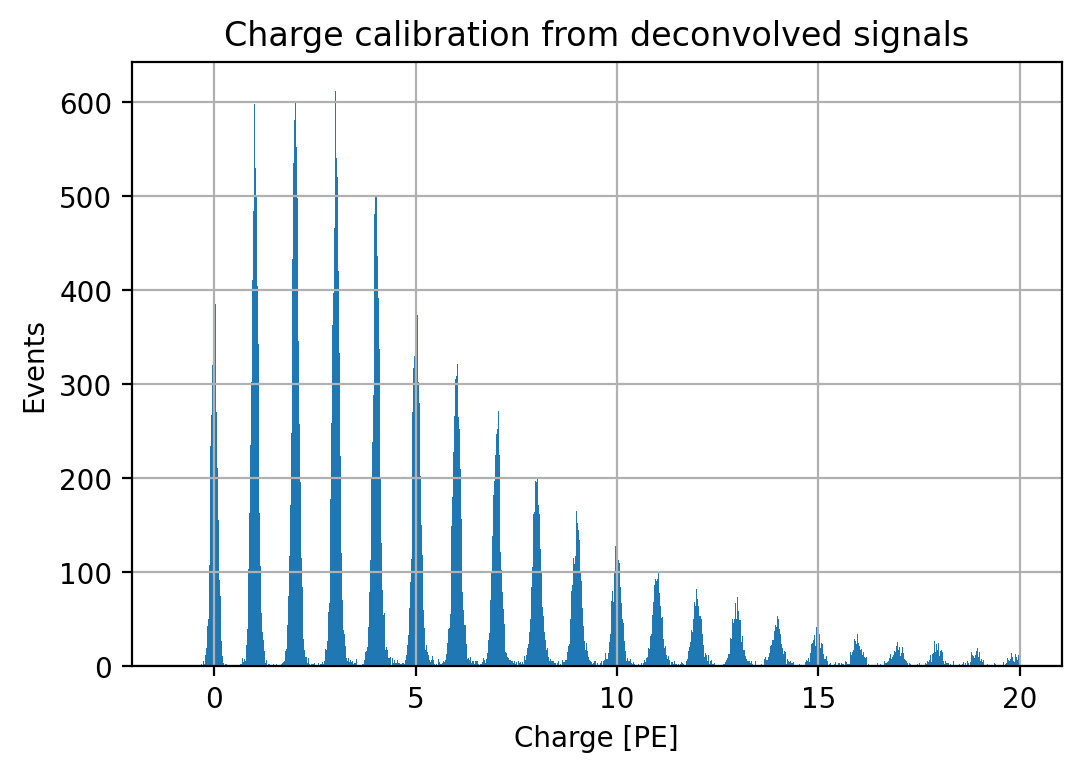

In [12]:
plt.figure(dpi=200)
plt.hist(charge,1000,[-1,20]);
# plt.semilogy()
plt.xlabel("Charge [PE]")
plt.ylabel("Events")
plt.title("Charge calibration from deconvolved signals")
plt.grid()

## FIT

[  298.   -30.   100.   449.  2220.   100.   474.  4470.   100.   464.
  6810.   100.   389.  9060.   100.   336. 11310.   100.   286. 13740.
   100.   226. 15720.   100.   188. 18330.   100.   138. 20130.   100.
   120. 22560.   100.    84. 24900.   100.    70. 27420.   100.    61.
 29310.   100.]
17.902600766616874


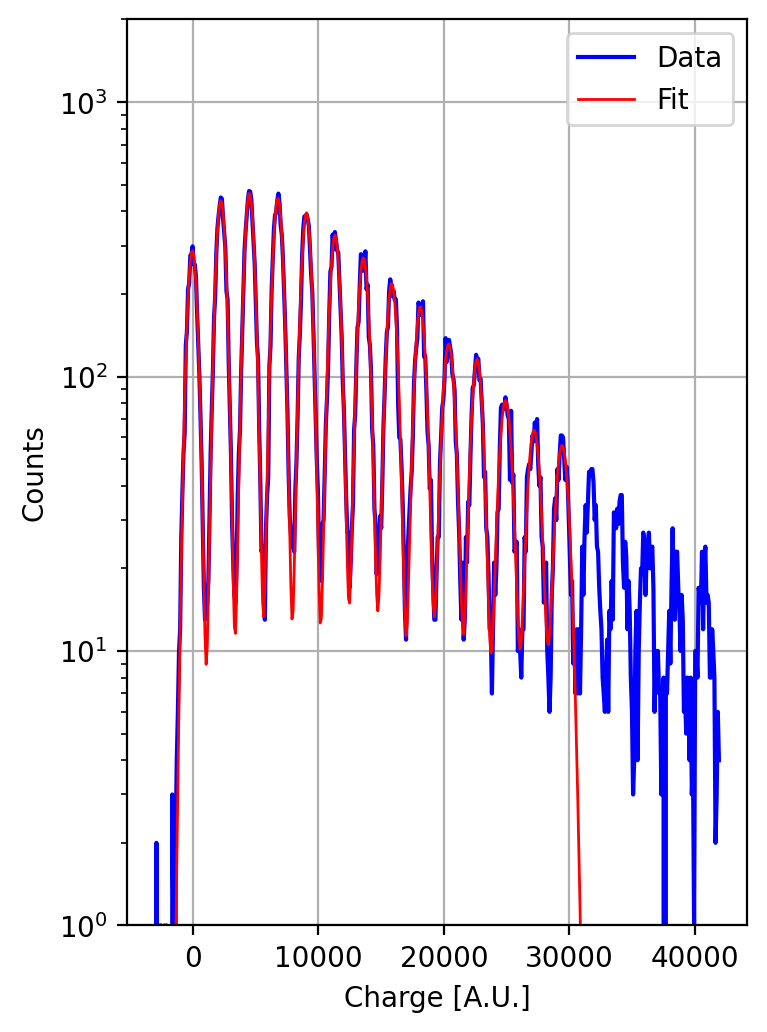

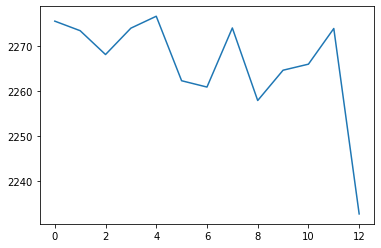

In [125]:
%matplotlib inline

def gauss(x,a,x0,sigma):
    return a*np.exp(-0.5*np.power((x-x0)/sigma,2))

def gaussian_train(x, *params):
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        height = params[i]
        center = params[i+1]
        width  = params[i+2]
        y      +=  gauss(x, height, center, width)
    return y

def fit_gaussians(x, y, *p0):
    assert x.shape == y.shape, "Input arrays must have the same shape."
    print(p0[0])
    # try:
    popt, pcov = curve_fit(gaussian_train, x,y, p0=p0[0])
    fit_y=gaussian_train(x,*popt)
    chi_squared = np.sum((y[abs(fit_y)>0.1] - fit_y[abs(fit_y)>0.1]) ** 2 / fit_y[abs(fit_y)>0.1]) / (y.size - len(popt))
    plt.figure(dpi=200, figsize=(4, 6))
    fig = plt.axes()
    plt.plot(x, y, 'b-', label='data')
    plt.plot(x, fit_y, 'r-', label='fit',linewidth=1)
    plt.grid()
    return popt,fig, chi_squared
    # except:
    #     print("Fit failed.")


params=np.zeros(len(peaks[0])*3)
params[0::3]=peaks[1]["peak_heights"]
params[1::3]=bins[peaks[0]]
params[2::3]=1e2
vars,fig,qs=fit_gaussians(bins[:-1],counts,params)
# print(vars*1e-6)
# fig.set_xlim([-1e4,0.98e4])
fig.set_xlabel("Charge [A.U.]")
fig.set_ylabel("Counts")
fig.legend(["Data","Fit"],loc="upper right")

gains=vars[1::3]-vars[1]
gains=gains[1:]-gains[0:-1]
# fig.text(0.4e8,430,"X-ARAPUCA Gain [1e6] \n =%0.2f" % (gains[0]*1e-6));
print(qs)

plt.figure()
plt.plot(gains)
fig.set_ylim([1,2e3])
fig.set_yscale("log")

In [8]:
# SAMPLING=4e-9
# BITS= 16384
# DYNAMIC_RANGE= 2
# AMP= np.array([250,250,250,250,1030])
# e_charge=1.60217663 * 1e-19

# #                           ADCs to V     ticks to sec          C to e-      still need to correct by Gain of specific run
# ADCxTicks2e=       DYNAMIC_RANGE/BITS     * SAMPLING  / AMP  /e_charge
# GAIN=np.array([6.36E+06,	6.61E+06,	6.66E+06,	6.63E+06,	3.00E+06]) #from calibrations, AT 4/2.5v
# ADCxTicks2PE=ADCxTicks2e/GAIN
